## DATASET USED : ANDROID MALWARE DETECTION 
(https://www.kaggle.com/datasets/subhajournal/android-malware-detection)
CLASSES AND DISTRIBUTION : Android_Adware         147443,
Android_Scareware      117081,
Android_SMS_Malware     67394,
Benign                  23708
### MODELS USED : SVM, DECISION TREE, RANDOM FOREST, LGBM
ACCURACY 
- SVM : 0.5567960070860164 
- DecisionTree : 0.5337288755166887 
- RandomForest : 0.6315693276720187 
- LGBM : 0.427 


In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv("/kaggle/input/android-malware-detection/Android_Malware.csv")
df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,172.217.6.202-10.42.0.211-443-50004-6,10.42.0.211,50004,172.217.6.202,443.0,6.0,13/06/2017 11:52:39,37027,1,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
1,1,172.217.6.202-10.42.0.211-443-35455-6,10.42.0.211,35455,172.217.6.202,443.0,6.0,13/06/2017 11:52:39,36653,1,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
2,2,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,51775,131.253.61.68,443.0,6.0,13/06/2017 11:52:42,534099,8,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
3,3,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,51775,131.253.61.68,443.0,6.0,13/06/2017 11:52:43,9309,3,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
4,4,131.253.61.68-10.42.0.211-443-51776-6,10.42.0.211,51776,131.253.61.68,443.0,6.0,13/06/2017 11:52:42,19890496,8,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware


In [ ]:
df.columns

Index(['Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
       ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Len

In [ ]:
df=df.dropna()
df=df.iloc[:,1:]
df=df.drop(' Timestamp',axis=1)
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.217.6.202-10.42.0.211-443-50004-6,10.42.0.211,50004,172.217.6.202,443.0,6.0,37027,1,1,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
1,172.217.6.202-10.42.0.211-443-35455-6,10.42.0.211,35455,172.217.6.202,443.0,6.0,36653,1,1,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
2,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,51775,131.253.61.68,443.0,6.0,534099,8,12,1011.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
3,131.253.61.68-10.42.0.211-443-51775-6,10.42.0.211,51775,131.253.61.68,443.0,6.0,9309,3,0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware
4,131.253.61.68-10.42.0.211-443-51776-6,10.42.0.211,51776,131.253.61.68,443.0,6.0,19890496,8,6,430.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Android_Adware


In [ ]:
print(df['Label'].value_counts())


Android_Adware         147443
Android_Scareware      117081
Android_SMS_Malware     67394
Benign                  23708
Name: Label, dtype: int64


In [ ]:
labels = sorted(df['Label'].unique().tolist())
N = list(range(len(labels)))
normal_mapping = dict(zip(labels,N))
print(normal_mapping)
reverse_mapping = dict(zip(N,labels))       
df['Label'] = df['Label'].map(normal_mapping)
print(df['Label'].value_counts())

{'Android_Adware': 0, 'Android_SMS_Malware': 1, 'Android_Scareware': 2, 'Benign': 3}
0    147443
2    117081
1     67394
3     23708
Name: Label, dtype: int64


In [ ]:
print(df[' CWE Flag Count'].unique().tolist())
df = df.drop(' CWE Flag Count',axis=1)
df.head(2)

[0, '0']


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,172.217.6.202-10.42.0.211-443-50004-6,10.42.0.211,50004,172.217.6.202,443.0,6.0,37027,1,1,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,172.217.6.202-10.42.0.211-443-35455-6,10.42.0.211,35455,172.217.6.202,443.0,6.0,36653,1,1,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
df[' Down/Up Ratio'] = pd.to_numeric(df[' Down/Up Ratio'],downcast="integer")
print(df[' Down/Up Ratio'].unique().tolist())

[1, 0, 2, 3, 8, 4, 5, 9, 6, 12, 7, 10, 11, 75]


In [ ]:
df = df.drop('Fwd Avg Bytes/Bulk',axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        #print(c)
        if df[c].dtype=='object': 
            #df[c] = df[c].fillna('missing')
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

data = labelencoder(df)

In [ ]:

y = data[['Label']]
x = data.drop([['Label'][0]],axis=1)


In [ ]:
x.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,133842,9,50004,1283,443.0,6.0,37027,1,1,0.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,133816,9,35455,1283,443.0,6.0,36653,1,1,0.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,111350,9,51775,648,443.0,6.0,534099,8,12,1011.0,...,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,111350,9,51775,648,443.0,6.0,9309,3,0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,111351,9,51776,648,443.0,6.0,19890496,8,6,430.0,...,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(x,y,test_size = 0.2)


In [ ]:
from contextlib import contextmanager
from time import time

In [ ]:
def create_numeric_feature(input_df):
    use_columns = x.columns 
    return input_df[use_columns].copy()


class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [ ]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [ ]:
train_feat_df = to_feature(X_train)
test_feat_df = to_feature(X_test)

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


createcreate_numeric_feature  0.169[s]


100%|██████████| 1/1 [00:00<00:00, 11.18it/s]

createcreate_numeric_feature  0.034[s]


In [ ]:
train_feat_df.dtypes.tolist

<bound method IndexOpsMixin.tolist of Flow ID                int64
 Source IP             int64
 Source Port           int64
 Destination IP        int64
 Destination Port    float64
                      ...   
 Active Min          float64
Idle Mean            float64
 Idle Std            float64
 Idle Max            float64
 Idle Min            float64
Length: 81, dtype: object>

In [ ]:
import pickle
import sklearn.ensemble as ek
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")


model = {"SVM":svm.SVC() ,
        "DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
        "RandomForest":ek.RandomForestClassifier(n_estimators=50)
}
results = {}
for algo in model:
    clf = model[algo]
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

SVM : 0.5567960070860164 
DecisionTree : 0.5337288755166887 
RandomForest : 0.6315693276720187 


In [ ]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}


In [ ]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [ ]:
yy = y_train
ydf=pd.DataFrame(yy)
ydf

,Label
145237,0
274832,1
270637,1
238389,2
56612,0
...,...
318725,1
335897,3
265726,1
72604,0


[500]	valid_0's rmse: 0.899249
[1000]	valid_0's rmse: 0.883644
[1500]	valid_0's rmse: 0.87337
[2000]	valid_0's rmse: 0.867058
[2500]	valid_0's rmse: 0.862899
[3000]	valid_0's rmse: 0.858251
[3500]	valid_0's rmse: 0.854484
[4000]	valid_0's rmse: 0.852034
[4500]	valid_0's rmse: 0.850295
[5000]	valid_0's rmse: 0.848391
[5500]	valid_0's rmse: 0.846606
[6000]	valid_0's rmse: 0.845558
[6500]	valid_0's rmse: 0.844446
[7000]	valid_0's rmse: 0.84339
[7500]	valid_0's rmse: 0.842734
[8000]	valid_0's rmse: 0.842223
[8500]	valid_0's rmse: 0.841498
fit fold=0  323.890[s]
Fold 0 RMSLE: 0.8414

[500]	valid_0's rmse: 0.897711
[1000]	valid_0's rmse: 0.883329
[1500]	valid_0's rmse: 0.874168
[2000]	valid_0's rmse: 0.866639
[2500]	valid_0's rmse: 0.862322
[3000]	valid_0's rmse: 0.8581
[3500]	valid_0's rmse: 0.854377
[4000]	valid_0's rmse: 0.851595
[4500]	valid_0's rmse: 0.849261
[5000]	valid_0's rmse: 0.846962
[5500]	valid_0's rmse: 0.845346
[6000]	valid_0's rmse: 0.843615
fit fold=1  243.669[s]
Fold 1 RMS

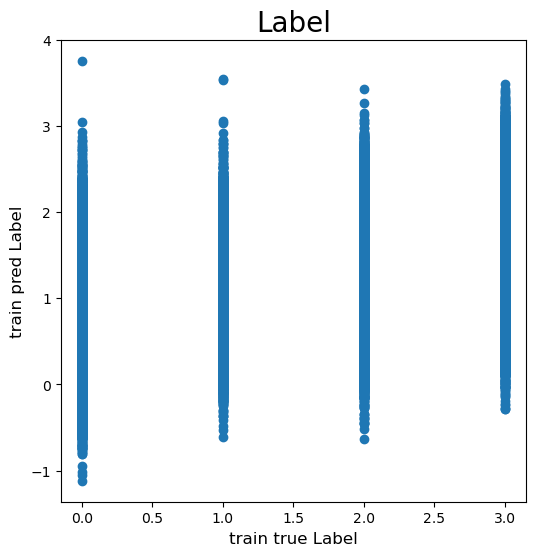

In [ ]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits = 3, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(['Label'][i],fontsize=20)
    ax.set_ylabel('train pred '+['Label'][i],fontsize=12)
    ax.set_xlabel('train true '+['Label'][i],fontsize=12)
    ax.scatter(y,oof)

[500]	valid_0's rmse: 0.897074
[1000]	valid_0's rmse: 0.881358
[1500]	valid_0's rmse: 0.870455
[2000]	valid_0's rmse: 0.86309
[2500]	valid_0's rmse: 0.855906
[3000]	valid_0's rmse: 0.850659
[3500]	valid_0's rmse: 0.847161
[4000]	valid_0's rmse: 0.844462
[4500]	valid_0's rmse: 0.841234
[5000]	valid_0's rmse: 0.838991
[5500]	valid_0's rmse: 0.836889
[6000]	valid_0's rmse: 0.835095
[6500]	valid_0's rmse: 0.833853
[7000]	valid_0's rmse: 0.832415
[7500]	valid_0's rmse: 0.831199
[8000]	valid_0's rmse: 0.830169
fit fold=0  350.304[s]
Fold 0 RMSLE: 0.8298

[500]	valid_0's rmse: 0.899454
[1000]	valid_0's rmse: 0.882977
[1500]	valid_0's rmse: 0.872359
[2000]	valid_0's rmse: 0.864314
[2500]	valid_0's rmse: 0.858171
[3000]	valid_0's rmse: 0.853885
[3500]	valid_0's rmse: 0.849654
[4000]	valid_0's rmse: 0.846728
[4500]	valid_0's rmse: 0.843623
[5000]	valid_0's rmse: 0.841568
[5500]	valid_0's rmse: 0.839602
[6000]	valid_0's rmse: 0.838187
[6500]	valid_0's rmse: 0.836829
[7000]	valid_0's rmse: 0.83553

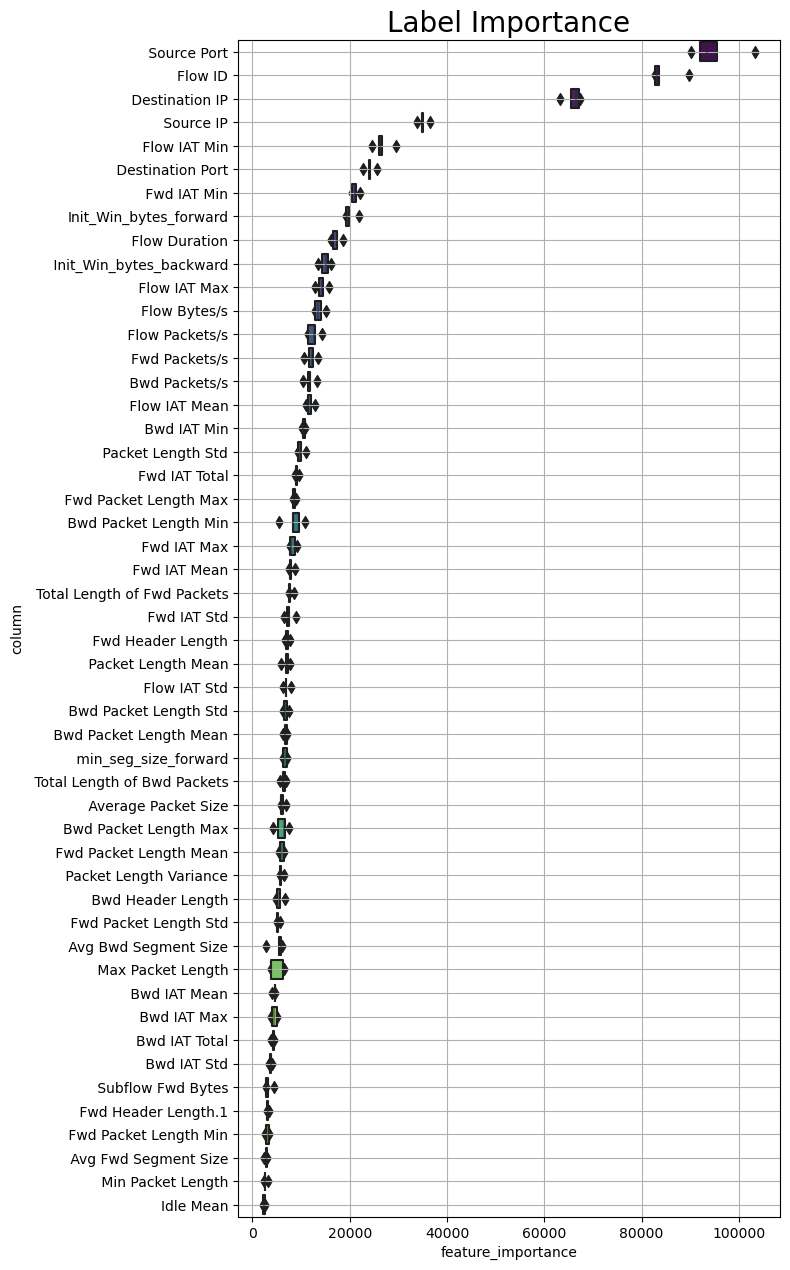

In [ ]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)
for i in range(1):
    fold = KFold(n_splits=3, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(['Label'][i]+' Importance',fontsize=20)

In [ ]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
preds2=[]
preds3=[]
for item in predsT:
    value=sum(item)
    preds2+=[value]
    preds3+=[int(round(np.clip(value,-0.4,3.4),0))]
print(preds2[0:5])

[0.1075833272264707, 0.6692312981445181, 0.7000391417708761, 1.4696510390448942, 1.030149396495183]


In [ ]:
test_true= y_test
test_pred = preds3
from sklearn.metrics import classification_report
print(classification_report(test_true, test_pred, target_names=labels, digits=3))

                     precision    recall  f1-score   support

     Android_Adware      0.942     0.357     0.518     29510
Android_SMS_Malware      0.243     0.834     0.377     13493
  Android_Scareware      0.622     0.356     0.453     23407
             Benign      0.783     0.047     0.088      4716

           accuracy                          0.427     71126
          macro avg      0.647     0.398     0.359     71126
       weighted avg      0.693     0.427     0.441     71126

